In [3]:
import os
import shutil
import glob
import random

def copy_files(source_folder, files_list, destination):
    for file in files_list:
        source_file = os.path.join(source_folder, file)
        destination_file = os.path.join(destination, file)
        shutil.copy2(source_file, destination_file)
        print(f"Copied {file} to {destination}")

def move_files(source_folder, destination):
    files_list = os.listdir(source_folder)
    for file in files_list:
        source_file = os.path.join(source_folder, file)
        destination_file = os.path.join(destination, file)
        shutil.move(source_file, destination_file)
        print(f"Moved {file} to {destination}")

def rename_file(file_path, new_name):
    directory = os.path.dirname(file_path)
    new_file_path = os.path.join(directory, new_name)
    os.rename(file_path, new_file_path)
    print(f"File renamed to {new_file_path}")

def pick_random_files(folder, count):
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    return random.sample(all_files, min(len(all_files), count))

# Define paths
base_path = "/workspaces/finetune/organized_categories"
tmp = os.path.join(base_path, "tmp")
op_path_similar = os.path.join(base_path, "similar_all_images")
op_path_dissimilar = os.path.join(base_path, "dissimilar_all_images")

# Ensure the operational directories exist
os.makedirs(tmp, exist_ok=True)
os.makedirs(op_path_similar, exist_ok=True)
os.makedirs(op_path_dissimilar, exist_ok=True)

# Generate folders list
folders_list = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
folders_list = list(set(folders_list) - {tmp, op_path_similar, op_path_dissimilar})

# Shuffle and process folders
random.shuffle(folders_list)
g, l = 0, 0  # Counters for similar and dissimilar pairs

for i in range(len(folders_list)):
    folder = folders_list[i]
    picked_files = pick_random_files(folder, 2)  # Try to pick 2 files from each folder
    if len(picked_files) < 2:
        print(f"Not enough files in {folder} to process (needed 2, found {len(picked_files)}). Skipping...")
        continue

    # Handle similar files
    copy_files(folder, picked_files, tmp)
    rename_file(os.path.join(tmp, picked_files[0]), f"similar_{g}_first.jpg")
    rename_file(os.path.join(tmp, picked_files[1]), f"similar_{g}_second.jpg")
    g += 1
    move_files(tmp, op_path_similar)

    # Handle dissimilar files
    if i+1 < len(folders_list):  # Ensure there is another folder to pick from
        next_folder = folders_list[i+1]
        next_folder_files = pick_random_files(next_folder, 1)
        if len(next_folder_files) < 1:
            print(f"Not enough files in {next_folder} to process for dissimilar pair. Skipping...")
            continue

        # Copy one file from each of two different folders
        dissimilar_files = [picked_files[0], next_folder_files[0]]
        copy_files(folder, [picked_files[0]], tmp)
        copy_files(next_folder, [next_folder_files[0]], tmp)
        
        rename_file(os.path.join(tmp, picked_files[0]), f"dissimilar_{l}_first.jpg")
        rename_file(os.path.join(tmp, next_folder_files[0]), f"dissimilar_{l}_second.jpg")
        l += 1
        move_files(tmp, op_path_dissimilar)



Copied 3001529018(9).jpg to /workspaces/finetune/organized_categories/tmp
Copied 3001529018(14).jpg to /workspaces/finetune/organized_categories/tmp
File renamed to /workspaces/finetune/organized_categories/tmp/similar_0_first.jpg
File renamed to /workspaces/finetune/organized_categories/tmp/similar_0_second.jpg
Moved similar_0_second.jpg to /workspaces/finetune/organized_categories/similar_all_images
Moved similar_0_first.jpg to /workspaces/finetune/organized_categories/similar_all_images
Copied 3001529018(9).jpg to /workspaces/finetune/organized_categories/tmp
Copied 3000325604(1).jpg to /workspaces/finetune/organized_categories/tmp
File renamed to /workspaces/finetune/organized_categories/tmp/dissimilar_0_first.jpg
File renamed to /workspaces/finetune/organized_categories/tmp/dissimilar_0_second.jpg
Moved dissimilar_0_first.jpg to /workspaces/finetune/organized_categories/dissimilar_all_images
Moved dissimilar_0_second.jpg to /workspaces/finetune/organized_categories/dissimilar_all_

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import functional
import numpy as np
import random

class ImagePairDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize the input image to 256x256
            transforms.ToTensor()           # Convert the image to a tensor
        ])
        self.image_pairs = self.load_image_pairs()

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image1_path, image2_path, label = self.image_pairs[idx]
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
        image1 = self.transform(image1)
        image2 = self.transform(image2)

        return image1, image2, label

    def load_image_pairs(self):
        image_pairs = []
        similar_dir = os.path.join(self.root_dir, "similar_all_images")
        dissimilar_dir = os.path.join(self.root_dir, "dissimilar_all_images")

        # Load similar image pairs with label 1
        similar_images = os.listdir(similar_dir)
        for i in range(0, len(similar_images), 2):
            image1_path = os.path.join(similar_dir, similar_images[i])
            image2_path = os.path.join(similar_dir, similar_images[i + 1])
            image_pairs.append((image1_path, image2_path, 1))  # Label 1 for similar

        # Load dissimilar image pairs with label 0
        dissimilar_images = os.listdir(dissimilar_dir)
        for i in range(0, len(dissimilar_images), 2):
            image1_path = os.path.join(dissimilar_dir, dissimilar_images[i])
            image2_path = os.path.join(dissimilar_dir, dissimilar_images[i + 1])
            image_pairs.append((image1_path, image2_path, 0))  # Label 0 for dissimilar

        return image_pairs

# Set the dataset root directory
dataset = ImagePairDataset("/workspaces/finetune/test_data/data_558/similar")

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/finetune/test_data/data_558/similar/similar_all_images'

In [7]:
import torch.nn as nn
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        # self.cnn1 = nn.Sequential(
        #     nn.Conv2d(3, 256, kernel_size=11,stride=4),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(3, stride=2),
            
        #     nn.Conv2d(256, 256, kernel_size=5, stride=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2, stride=2),

        #     nn.Conv2d(256, 384, kernel_size=3,stride=1),
        #     nn.ReLU(inplace=True)
        # )
        
        self.cnn1=nn.Conv2d(3, 256, kernel_size=11,stride=4)
        self.relu = nn.ReLU()
        self.maxpool1=nn.MaxPool2d(3, stride=2)
        self.cnn2=nn.Conv2d(256, 256, kernel_size=5,stride=1)
        self.maxpool2=nn.MaxPool2d(2, stride=2)
        self.cnn3=nn.Conv2d(256, 384, kernel_size=3,stride=1)
        self.fc1 =nn.Linear(46464, 1024)
        self.fc2=nn.Linear(1024, 256)
        self.fc3=nn.Linear(256, 1)
        # Setting up the Fully Connected Layers
        # self.fc1 = nn.Sequential(
        #     nn.Linear(384, 1024),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(1024, 32*46464),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(32*46464,1)
        # )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        # output = self.cnn1(x)
        # print(output.view(output.size()[0], -1).shape)
        # output = output.view(output.size()[0], -1)
        # output = self.fc1(output)
        # print(x.shape)
        output= self.cnn1(x)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool1(output)
        # print(output.shape)
        output= self.cnn2(output)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool2(output)
        # print(output.shape)
        output= self.cnn3(output)
        output=self.relu(output)
        # print(output.shape)
        output=output.view(output.size()[0], -1)
        # print(output.shape)
        output=self.fc1(output)
        # print(output.shape)
        output=self.fc2(output)
        # print(output.shape)
        output=self.fc3(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
import torch.optim as optim

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive
      
net = SiameseNetwork()
if torch.cuda.is_available():
    net = net.cuda()
else:
    print("CUDA is not available. Using CPU instead.")
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

CUDA is not available. Using CPU instead.


Using device: cpu
Epoch number 0
 Current loss 1.0890170335769653

Epoch number 1
 Current loss 1.0954452753067017

Epoch number 2
 Current loss 1.0494179725646973

Epoch number 3
 Current loss 1.001436471939087

Epoch number 4
 Current loss 1.074585199356079

Epoch number 5
 Current loss 1.0849826335906982

Epoch number 6
 Current loss 0.9979870319366455

Epoch number 7
 Current loss 0.985958456993103

Epoch number 8
 Current loss 1.054372787475586

Epoch number 9
 Current loss 1.0436546802520752

Model saved to /workspaces/finetune/model/weights.pth


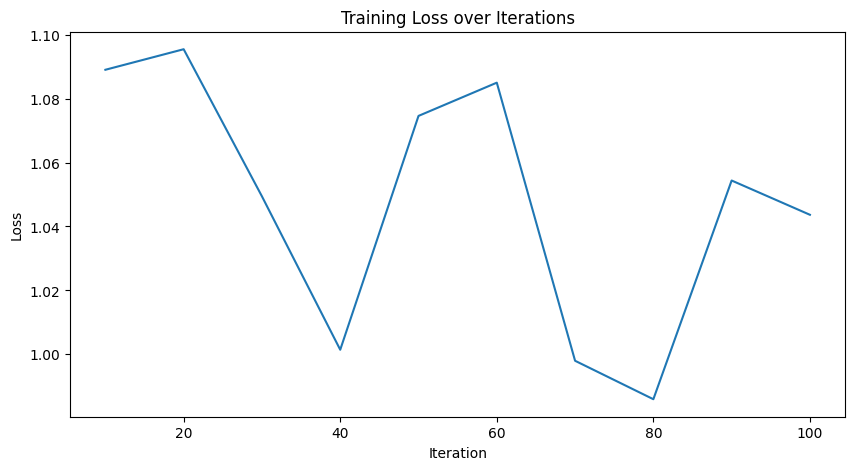

In [30]:
import matplotlib.pyplot as plt

# Set device to CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the appropriate device
net.to(device)
criterion.to(device)

# Initialize counters and history for tracking progress
counter = []
loss_history = []
iteration_number = 0

# Iterate through the epochs
for epoch in range(10):
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_loader):
        # Send the images and labels to the designated device
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches, print out the loss and update history
        if i % 10 == 0:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

# After the training loop
model_path = '/workspaces/finetune/model/weights.pth'
torch.save(net.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Function to show loss over iterations
def show_plot(iteration, loss):
    plt.figure(figsize=(10, 5))
    plt.plot(iteration, loss)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.show()

show_plot(counter, loss_history)


In [33]:
#at inference

In [34]:
# Assuming the model is defined as SiameseNetwork
model = SiameseNetwork()

# Load the trained weights (substitute your model's saved weights path)
model.load_state_dict(torch.load('/workspaces/finetune/model/weights.pth'))
model.eval()
model.to(device)

SiameseNetwork(
  (cnn1): Conv2d(3, 256, kernel_size=(11, 11), stride=(4, 4))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46464, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

In [35]:
from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Add normalization if it was used during training
])

def load_and_transform_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

In [36]:
def infer_similarity(reference_image_path, comparison_images_folder):
    reference_image = load_and_transform_image(reference_image_path).unsqueeze(0).to(device)
    
    # Load and process each comparison image
    similarities = []
    for image_name in os.listdir(comparison_images_folder):
        image_path = os.path.join(comparison_images_folder, image_name)
        comparison_image = load_and_transform_image(image_path).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Get the feature vectors
            output_ref = model.forward_once(reference_image)
            output_comp = model.forward_once(comparison_image)
            
            # Calculate the Euclidean distance or another similarity metric
            similarity = F.pairwise_distance(output_ref, output_comp)
            similarities.append((image_name, similarity.item()))
    
    # Sort by similarity
    similarities.sort(key=lambda x: x[1])
    return similarities


In [46]:
def show_images(image_paths):
    if not image_paths:
        print("No images to display.")
        return

    # If there are images, display them
    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 10))
    if len(image_paths) == 1:  # When there is only one image, axes is not a list
        axes = [axes]
    for ax, img_path in zip(axes, image_paths):
        image = Image.open("data_test/"+img_path)
        ax.imshow(image)
        ax.axis('off')
    plt.show()


In [48]:
reference_path = '/workspaces/finetune/data_test/3001757846(39).jpg'
comparison_folder = '/workspaces/finetune/data_test'

# Get the top 5 most similar images
similarities = infer_similarity(reference_path, comparison_folder)
top_5_similar = similarities[:5]

img_list = []
for img, score in top_5_similar:
    img_list.append(img)
    print(f"Image: {img}, Similarity Score: {score}")

Image: 3001757846(39).jpg, Similarity Score: 9.999999974752427e-07
Image: 2999489942(4).jpg, Similarity Score: 0.003594683250412345
Image: 2999267279(5).jpg, Similarity Score: 0.009136153385043144
Image: 3000000006(1).JPG, Similarity Score: 0.011157320812344551
Image: 2998769081(2).JPG, Similarity Score: 0.021125270053744316


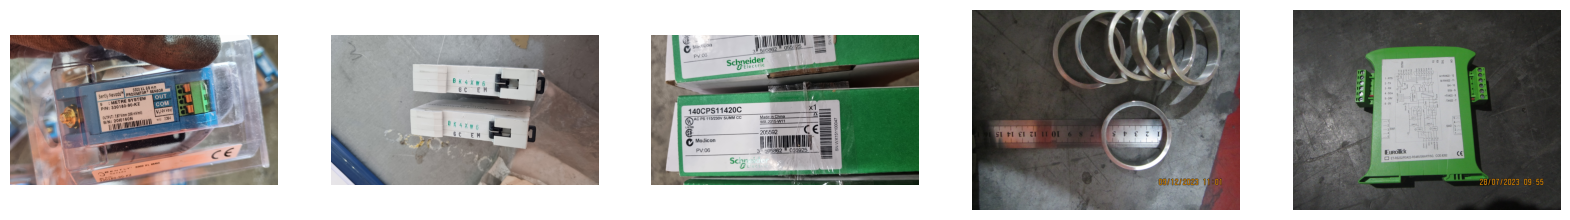

In [49]:
show_images(img_list)